# Generative Adversarial Network (GAN)

## Librairies

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

## Dataset

In [2]:
batch_size = 256

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## GAN

In [4]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

output_dir = "output_gan"
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Generator (CNN)

class Generator(nn.Module):
    def __init__(self, zdim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(zdim, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128,7,7)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 7, padding=3),
            nn.Tanh()
        )
    def forward(self, z): return self.net(z)

In [6]:
# Discriminator (CNN)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(64*7*7, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

In [7]:
latent_dim = 100

gen = Generator(latent_dim).to(device)
disc = Discriminator().to(device)

opt_g = optim.Adam(gen.parameters(), lr=1e-4)
opt_d = optim.Adam(disc.parameters(), lr=1e-4)
criterion = nn.BCELoss() # BCE loss here! (less complicated than in the course...)

In [8]:
gen

Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (11): Tanh()
  )
)

In [9]:
disc

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [10]:
# Noise used to generate 5x5=25 images
fixed_noise = torch.randn(25, latent_dim, device=device)
fixed_noise, fixed_noise.shape

(tensor([[-0.7918,  0.8784,  0.7052,  ..., -0.2446, -1.8642, -2.8237],
         [-0.9306,  0.9589, -0.7488,  ...,  1.2517, -0.2071, -0.7672],
         [ 2.7434,  0.7779,  1.6877,  ..., -1.0529,  0.8627, -0.4869],
         ...,
         [ 0.1477,  0.0690,  0.1362,  ...,  1.1488, -0.5729, -1.4219],
         [-0.4770,  0.4398,  1.7629,  ..., -0.4665, -0.1270, -1.0620],
         [-0.8875, -0.4603, -1.2234,  ..., -0.3437, -1.0280, -0.1222]],
        device='mps:0'),
 torch.Size([25, 100]))

In [11]:
# Training loop

epochs = 200
save_every = 5

print("Device:", device)

start = time.time()

for epoch in range(1, epochs+1):
    
    g_losses = []; d_losses = []
    
    for real, _ in dataloader: # real data
        
        real = real.to(device)
        b = real.size(0)
        real_labels = torch.ones(b, 1, device=device)     # y=1 (i.e. real images)
        fake_labels = torch.zeros(b, 1, device=device)    # y=0 (i.e. fake images)

        # === D update === #
        opt_d.zero_grad()
        
        # 1. Train D on real data
        # y = 1 => D(x) = Pr(y=1 | x) ~ 1
        out_real = disc(real)                            # predictions D(x), for real x
        d_loss_real = criterion(out_real, real_labels)   # compare D(x) with y=1

        # 2. Train D on fake data, i.e., data generated by G
        # y = 0 => D(x) = Pr(y=0 | x) ~ 0
        z = torch.randn(b, latent_dim, device=device)   # noise
        fake = gen(z)                                   # generate fake data from noise
        out_fake = disc(fake.detach())                  # predictions D(x), for fake x
        d_loss_fake = criterion(out_fake, fake_labels)  # compare D(x) with y=0

        d_loss = d_loss_real + d_loss_fake              # compute total loss
        d_loss.backward()                               # backprop
        opt_d.step()                                    # update gradients

        # === G update === #
        # 3. Train G
        opt_g.zero_grad()                               # reset gradients
        out_fake_for_g = disc(fake)                     # predictions D(x), for fake x
        
        g_loss = criterion(out_fake_for_g, real_labels) # compute total loss
        g_loss.backward()                               # backprop
        opt_g.step()                                    # update gradients

        g_losses.append(g_loss.item()); d_losses.append(d_loss.item())

    print(f"Epoch {epoch}: gen_loss={np.mean(g_losses):.4f}, disc_loss={np.mean(d_losses):.4f}")
    
    if epoch % save_every == 0 or epoch==1 or epoch==epochs:
        
        with torch.no_grad():
            
            samples = gen(fixed_noise).cpu()            # generate fake data
            samples = (samples + 1) / 2.0               # rescales G's tanh activation: [-1, +1] -> [0, 1]
            grid = make_grid(samples, nrow=5)
            fname = os.path.join(output_dir, f"generated_epoch_{epoch}.png")
            save_image(grid, fname)
            print("Saved", fname)

print("Done in {:.1f}s".format(time.time()-start))

# Save models
torch.save(gen.state_dict(), os.path.join(output_dir, "gen.pth"))
torch.save(disc.state_dict(), os.path.join(output_dir, "disc.pth"))
print("\nSaved weights to", output_dir)

Device: mps
Epoch 1: gen_loss=0.6863, disc_loss=1.2655
Saved output_gan/generated_epoch_1.png
Epoch 2: gen_loss=0.7073, disc_loss=1.3770
Epoch 3: gen_loss=0.8173, disc_loss=1.2977
Epoch 4: gen_loss=0.7498, disc_loss=1.3651
Epoch 5: gen_loss=0.7013, disc_loss=1.4125
Saved output_gan/generated_epoch_5.png
Epoch 6: gen_loss=0.7042, disc_loss=1.3980
Epoch 7: gen_loss=0.7077, disc_loss=1.3902
Epoch 8: gen_loss=0.7181, disc_loss=1.3802
Epoch 9: gen_loss=0.7177, disc_loss=1.3884
Epoch 10: gen_loss=0.7064, disc_loss=1.3992
Saved output_gan/generated_epoch_10.png
Epoch 11: gen_loss=0.7859, disc_loss=1.3685
Epoch 12: gen_loss=0.7203, disc_loss=1.4031
Epoch 13: gen_loss=0.7034, disc_loss=1.4084
Epoch 14: gen_loss=0.7170, disc_loss=1.3724
Epoch 15: gen_loss=0.7155, disc_loss=1.3752
Saved output_gan/generated_epoch_15.png
Epoch 16: gen_loss=0.7217, disc_loss=1.3688
Epoch 17: gen_loss=0.7700, disc_loss=1.3275
Epoch 18: gen_loss=0.7334, disc_loss=1.3673
Epoch 19: gen_loss=0.7376, disc_loss=1.3550
Epo

**Remark: With GANs, the loss might seem stagnating, even if the training is actually improving...**

## Generate data

In [12]:
import os
import numpy as np
import torch
from torchvision.utils import save_image

In [42]:
with torch.no_grad():

    gen.eval()

    noise = torch.randn(25, latent_dim, device=device)

    samples = gen(noise).cpu()         # generate fake data
    samples = (samples + 1) / 2.0      # rescales G's tanh activation: [-1, +1] -> [0, 1]

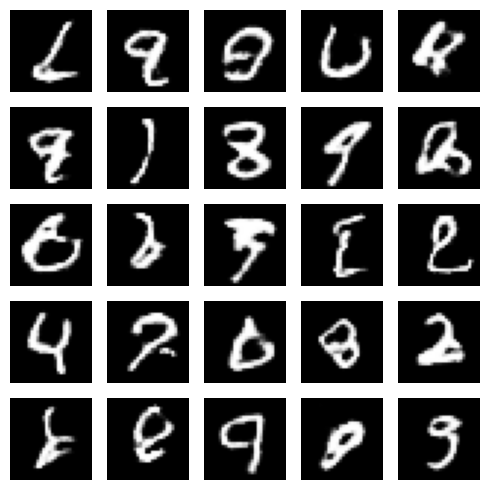

In [44]:
fig, axes = plt.subplots(5, 5, figsize=(5,5))
axes = axes.flatten()  # flatten 2D grid of axes to iterate easily

for i in range(25):
    img = samples[i, 0, :, :]        # take ith image, channel 0
    axes[i].imshow(img, cmap='gray') # show grayscale image
    axes[i].axis('off')              # remove axis ticks

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "generated_daat.pdf"))
plt.show()